### Imports 

In [91]:
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam
strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


### Load datasets

In [84]:
train_x = np.load("./data/train/training_data_x.npy")
train_y = np.load("./data/train/training_data_y.npy")

In [85]:
val_x = np.load("./data/val/validating_data_x.npy")
val_y = np.load("./data/val/validating_data_y.npy")

### Create model

#### Hyper-parameters

In [86]:
input_shape = (96, 96, 1)  

num_keypoints = 15   
batch_size = 32
epochs = 50 
output_units = num_keypoints * 2

learning_rate =0.001

#### Model architecture

In [87]:
def build_CNN_model(): 

    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_units, activation='relu'))

    return model

### Train the model

In [92]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    print("Using GPU for training.")
else:
    print("No GPUs available. Using CPU for training.")

No GPUs available. Using CPU for training.


In [93]:

model = build_CNN_model()
optimizer = Adam(learning_rate=learning_rate   )
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'accuracy'])

history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
                   validation_data=(val_x,val_y))
model.evaluate(val_x, val_y)

c:\Users\vinew\anaconda3\envs\kaggle-tf\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.1530 - loss: 3456.9426 - mae: 33.4417 - val_accuracy: 0.6150 - val_loss: 770.8020 - val_mae: 25.3790
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.2868 - loss: 242.3507 - mae: 12.0132 - val_accuracy: 0.6150 - val_loss: 592.8900 - val_mae: 22.3380
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - accuracy: 0.3203 - loss: 152.8263 - mae: 9.3658 - val_accuracy: 0.6150 - val_loss: 85.7007 - val_mae: 8.1612
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - accuracy: 0.3909 - loss: 111.8555 - mae: 7.9010 - val_accuracy: 0.6150 - val_loss: 41.3132 - val_mae: 5.5297
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 33s 222ms/step - accuracy: 0.4144 - loss: 104.6516 - mae: 7.6512 - val_accuracy: 0.6150 - val_loss: 26.8024 - val_mae: 4.3142
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 34s 230ms/step - accuracy: 0.4519 - loss: 99.5191 - mae: 7.4530 - val_accuracy: 0.6150 - val_loss: 17.2757 - val_mae: 3.282

[10.097562789916992, 2.074422597885132, 0.6149548888206482]

In [107]:
def draw_keypoints(image, predicted_keypoints, type ='Predicted'): 
    
    keypoint_labels = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']
    
    predicted_keypoints = pd.Series(predicted_keypoints,index=keypoint_labels)
    keypoints = {}
     
    # Extract keypoint pairs from the series
    for key in predicted_keypoints.index:
        if key.endswith('_x'):
            # Base name without the coordinate suffix
            base_name = key[:-2]
            x_value = predicted_keypoints[key]
            y_value = predicted_keypoints[base_name + '_y']
            keypoints[base_name] = (x_value, y_value)

    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot each keypoint
    for key, (x, y) in keypoints.items():
        plt.plot(x, y, 'ro')  # Red dots for keypoints
        plt.text(x, y, key, fontsize=6, color='lime')

    plt.title(f'{type} Facial Keypoints Detection')
    plt.show()

In [97]:
input_image = np.expand_dims(val_x[1], axis=-1)  

 
input_image = np.expand_dims(input_image, axis=0)   

# Make prediction
predicted_keypoints = model.predict(input_image)

# Output shape will be (1, num_keypoints), where num_keypoints is typically 30 (15 pairs of x and y)
predicted_keypoints = predicted_keypoints[0]  # Remove the batch dimension

# Example: printing the predicted keypoints
print("Predicted Keypoints:", predicted_keypoints)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Keypoints: [65.06388  36.624763 29.845438 37.40728  57.850857 36.109596 72.076515
 35.019638 36.6184   38.630913 22.203382 39.336765 52.651176 29.791437
 78.67234  28.265785 38.13016  32.25566  14.963751 34.201122 47.580986
 61.585484 68.28306  71.93678  33.980602 75.7432   49.67549  73.89789
 48.273945 77.456825]


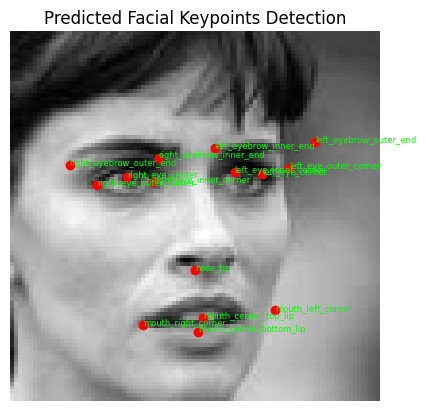

In [109]:
draw_keypoints(val_x[1],predicted_keypoints,"Predicted")

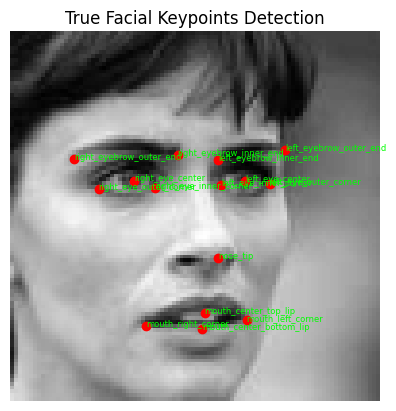

In [110]:
draw_keypoints(val_x[1],val_y[1],"True")